Let's improve our painter classifier! It's always a good idea to look at how other people have tackled a problem. 

Here are some links: 

http://cs231n.stanford.edu/reports/2017/pdfs/406.pdf

http://cs231n.stanford.edu/reports/2017/pdfs/410.pdf






I also want you to implement another painter into your dataset - Carel Fabritius, a scolar of Rembrandt. The reason is, that there are only 17 paintings of Fabritius left. Let's (along with other things) see how our model performs on such a small class. 

### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

### Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/
!mkdir local_all
!unzip '/content/drive/MyDrive/Colab Notebooks/Artwork_RNN_Quest/RNN_Quest.zip' -d local_all
!unzip '/content/drive/MyDrive/Colab Notebooks/Artwork_RNN_Quest/Fabritius.zip' -d local_all

In [4]:
# move Fabritius
!mv /content/local_all/Fabritius /content/local_all/RNN_Quest

In [5]:

# create directory strucuture for flow_gen
%cd /content/
!mkdir local_split
%cd /content/local_split/
!mkdir training_set
!mkdir test_set

/content
/content/local_split


In [6]:
classes_to_int = {
 'Albrecht_Duerer':0,
 'Caravaggio':1,
 'Fabritius':2,
 'Giotto_di_Bondone':3,
 'Leonardo_da_Vinci':4,
 'Michelangelo':5,
 'Raphael':6,
 'Rembrandt':7}


# get paths of images 

all_paths = []
y_class = []
for x in os.listdir('/content/local_all/RNN_Quest'): 
  path = '/content/local_all/RNN_Quest/' + x
  for y in os.listdir(path):
   all_paths.append('/content/local_all/RNN_Quest/' + x + '/' + y)
   y_class.append(classes_to_int[x])



In [7]:
data = []
for i in all_paths:
    # Load all artist's images stored in path
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb')
    image = np.asarray(image)
    image.astype(np.uint8)
    # append image to list data
    data.append(image)

# Build Train, Test Set

In [8]:
# split in train and test data


from sklearn.model_selection import train_test_split
X_train_all, X_test, y_train_all, y_test = train_test_split(data, y_class, test_size=0.2, random_state=42, stratify = y_class)

X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.2, random_state=42, stratify = y_train_all)

In [9]:
from collections import Counter
print('Train Label Distribution:')
print(Counter(y_train))

print('Test Label Distribution:')
print(Counter(y_val))

print('Test Label Distribution:')
print(Counter(y_test))

Train Label Distribution:
Counter({0: 210, 7: 168, 4: 91, 3: 76, 6: 70, 1: 35, 5: 31, 2: 11})
Test Label Distribution:
Counter({0: 52, 7: 42, 4: 23, 3: 19, 6: 17, 1: 9, 5: 8, 2: 3})
Test Label Distribution:
Counter({0: 66, 7: 52, 4: 29, 3: 24, 6: 22, 1: 11, 5: 10, 2: 3})


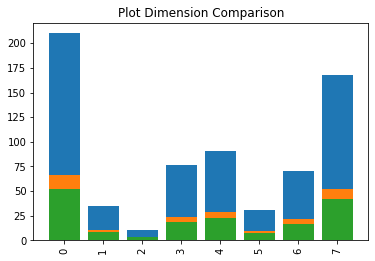

In [10]:
Train = Counter(y_train)
Val = Counter(y_val)
Test = Counter(y_test)

plt.title('Plot Dimension Comparison')
plt.bar(x = Train.keys() , height= Train.values())
plt.bar(x = Test.keys() , height= Test.values())
plt.bar(x = Val.keys() , height= Val.values())
plt.xticks(rotation = 90)
plt.show()

# Cropping

Now restructure your dataset so that you can implement Nitin Vishwanathans approach: Take one center crop and one random crop of each image. To do so, you need to write two functions, one to get a center crop of your image dimensions and one to get a random crop. 

In [11]:
from tensorflow.python.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [12]:
def get_center_crop(img, crop_size):
 height, width = img.shape[0], img.shape[1]
 dy, dx = crop_size
 x = (width - dx + 1) // 2
 y = (height - dy + 1) // 2
 return img[y:(y+dy), x:(x+dx), :]

In [13]:
def get_random_crop(img, random_crop_size):
# Note: image_data_format is 'channel_last'
 assert img.shape[2] == 3
 height, width = img.shape[0], img.shape[1]
 dy, dx = random_crop_size
 x = np.random.randint(0, width - dx + 1)
 y = np.random.randint(0, height - dy + 1)
 return img[y:(y+dy), x:(x+dx), :]

In [14]:
# Randomized Cropping for X_train

for i in range(len(X_train)): 
  X_train[i] = get_random_crop(X_train[i], random_crop_size=(224,224))
  
# Center Croping for X_train, X_validaion 

for i in range(len(X_val)): 
  X_val[i] = get_center_crop(X_val[i], crop_size=(224,224))

for i in range(len(X_test)): 
  X_test[i] = get_center_crop(X_test[i], crop_size=(224,224))


# Image Data Generator

In [15]:
batch_size = 8

############
# Training
############
train_gen = ImageDataGenerator(
    featurewise_center=True, # Zero Center
    samplewise_center=False,
    featurewise_std_normalization=True, # Normalization
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=None,
    shear_range=5.0,
    zoom_range=0.1,
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=True,   ### That is important, because Viswanathan dit it as well
    vertical_flip=False,
    rescale= None,
    preprocessing_function=None,
    data_format=None,
    dtype=None,
)
train_gen.fit(X_train)

train_batches = train_gen.flow(
    x = np.asarray(X_train),
    y=y_train,
    batch_size=batch_size,
    shuffle=True
)

############
# Validation
############

val_gen = ImageDataGenerator(
    featurewise_center=True, # Zero Center
    samplewise_center=False,
    featurewise_std_normalization=True, # Normalization
    samplewise_std_normalization=False,
    rescale = None
)
val_gen.fit(X_val)

val_batches = val_gen.flow(
    x = np.asarray(X_val),
    y=y_val,
    batch_size=batch_size,
    shuffle= True
)    

############
# Test
############
test_gen = ImageDataGenerator(
    featurewise_center=True, # Zero Center
    samplewise_center=False,
    featurewise_std_normalization=True, # Normalization
    samplewise_std_normalization=False,
    rescale = None
)
test_gen.fit(X_val)

test_batches = test_gen.flow(
    x = np.asarray(X_test),
    y=y_test,
    batch_size=batch_size,
    shuffle= False
)    


NOTE: you would not necessarily need to restructure the data set - if you wrote a custom data_generator who does the cropping for you. And check whether keras has this under the hood. But you might be unlucky...

Now take the models from RNN_Quest_1 - and feed them with the crops, rather than the resized images!

What is the performance? Did it improve? 

In [16]:
from keras.applications import VGG19
from keras.applications import ResNet50
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from keras.models import load_model
from keras.layers import Dense, Flatten, Dropout, ReLU, BatchNormalization
from keras.layers import MaxPooling2D, AveragePooling2D

from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint

# VGG19

In [17]:
# Load vgg19 model
vgg19 = VGG19(weights='imagenet', 
              include_top=False, 
              input_shape=(224, 224, 3),
              )

#vgg19.summary()

# Freeze the weights
vgg19.trainable = False

80142336/80134624 [==============================] - 1s 0us/step


In [18]:
# Add a new classifier and build a new model

# Get the output of vgg19's last layer
last_output = vgg19.layers[-1].output

# Flatten the classifier input which is the output of the last layer
x = Flatten()(last_output)

x = Dense(1024)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.5)(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dropout(0.3)(x)
x = Dense(64)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Dense(8, activation='softmax', name='softmax')(x)

my_vgg19 = Model(inputs=vgg19.input, outputs=x)



In [19]:
%cd '/content/drive/MyDrive/Colab Notebooks/Artwork_RNN_Quest'

/content/drive/MyDrive/Colab Notebooks/Artwork_RNN_Quest


In [20]:
# Create checkpoint
mcp_vgg19 = ModelCheckpoint('best_model_vgg19', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

In [21]:
# Compile the model
my_vgg19.compile(Adam(lr=0.0001), 
                  loss='sparse_categorical_crossentropy',
                  metrics='accuracy')

In [22]:
# Train the model
my_vgg19.fit(
    x=train_batches,
    validation_data=val_batches,
    epochs=25,
    verbose=1,
    callbacks=mcp_vgg19,
)

Epoch 1/25
87/87 [==============================] - 42s 115ms/step - loss: 2.0051 - accuracy: 0.2984 - val_loss: 1.4211 - val_accuracy: 0.5838

Epoch 00001: val_accuracy improved from -inf to 0.58382, saving model to best_model_vgg19
INFO:tensorflow:Assets written to: best_model_vgg19/assets
Epoch 2/25
87/87 [==============================] - 8s 96ms/step - loss: 1.4114 - accuracy: 0.5598 - val_loss: 1.1338 - val_accuracy: 0.6301

Epoch 00002: val_accuracy improved from 0.58382 to 0.63006, saving model to best_model_vgg19
INFO:tensorflow:Assets written to: best_model_vgg19/assets
Epoch 3/25
87/87 [==============================] - 9s 103ms/step - loss: 1.1502 - accuracy: 0.6427 - val_loss: 1.0073 - val_accuracy: 0.6994

Epoch 00003: val_accuracy improved from 0.63006 to 0.69942, saving model to best_model_vgg19
INFO:tensorflow:Assets written to: best_model_vgg19/assets
Epoch 4/25
87/87 [==============================] - 9s 98ms/step - loss: 1.0461 - accuracy: 0.6432 - val_loss: 0.9140 

# restnet50

In [23]:
# Load vgg19 model
resnet50 = ResNet50(weights='imagenet', 
                    include_top=False, 
                    input_shape=(224, 224, 3),
                    )

#restnet50.summary()

#for layer in resnet50.layers[:-40]:
#  layer.trainable = False

# Freeze the weights
resnet50.trainable = False

94773248/94765736 [==============================] - 2s 0us/step


In [24]:
# Add a new classifier and build a new model

last_output = resnet50.layers[-1].output
x = AveragePooling2D((2,2))(last_output)
# Flatten the classifier input which is the output of the last layer
x = Flatten()(x)
x = Dense(512, kernel_initializer='he_uniform')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Dense(16, kernel_initializer='he_uniform')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = ReLU()(x)
      
x = Dense(9, 
          kernel_initializer=initializers.he_normal(),
          bias_initializer=initializers.ones(), 
          activation='softmax')(x)

my_resnet50 = Model(inputs=resnet50.input, outputs=x)


In [25]:
# Create checkpoint
mcp_resnet50 = ModelCheckpoint('best_model_resnet50', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=1)

In [26]:
# Compile the model
my_resnet50.compile(Adam(lr=0.005), 
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

In [27]:
# Train the model
my_resnet50.fit(x=train_batches,
                validation_data=val_batches,
                epochs=25,
                verbose=1,
                callbacks=mcp_resnet50,
                )

Epoch 1/25
87/87 [==============================] - 11s 98ms/step - loss: 2.2126 - accuracy: 0.1680 - val_loss: 1.8606 - val_accuracy: 0.3179

Epoch 00001: val_accuracy improved from -inf to 0.31792, saving model to best_model_resnet50
INFO:tensorflow:Assets written to: best_model_resnet50/assets
Epoch 2/25
87/87 [==============================] - 8s 89ms/step - loss: 1.7910 - accuracy: 0.3094 - val_loss: 1.7889 - val_accuracy: 0.3815

Epoch 00002: val_accuracy improved from 0.31792 to 0.38150, saving model to best_model_resnet50
INFO:tensorflow:Assets written to: best_model_resnet50/assets
Epoch 3/25
87/87 [==============================] - 8s 88ms/step - loss: 1.7712 - accuracy: 0.3599 - val_loss: 1.7629 - val_accuracy: 0.3757

Epoch 00003: val_accuracy did not improve from 0.38150
Epoch 4/25
87/87 [==============================] - 8s 94ms/step - loss: 1.7118 - accuracy: 0.3823 - val_loss: 1.6983 - val_accuracy: 0.3815

Epoch 00004: val_accuracy did not improve from 0.38150
Epoch 5/

# Model Evaluation

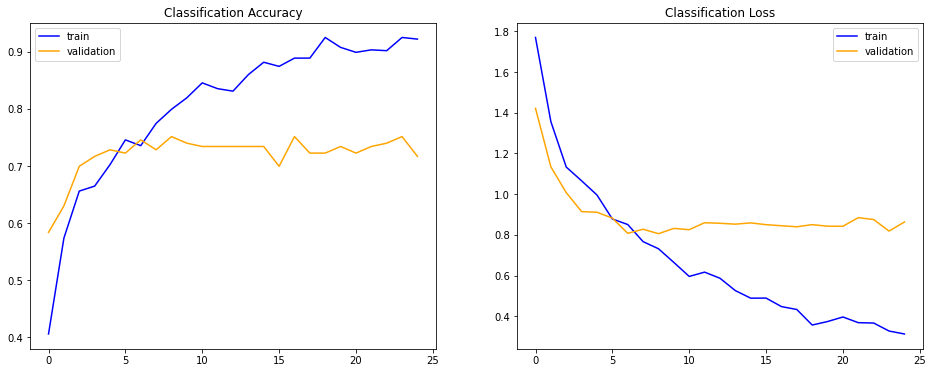

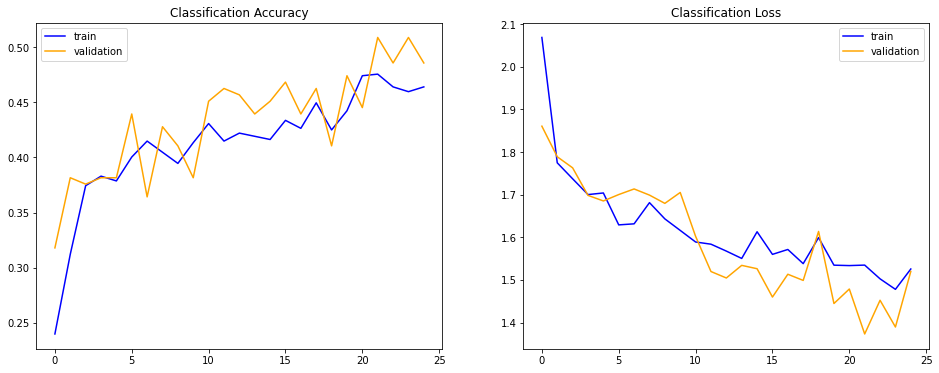

In [28]:
from tensorflow.python.keras.callbacks import History

def plot_training_history(history: History):
  plt.figure(figsize=(16,6))
  plt.subplot(1,2,1)
  plt.title('Classification Accuracy')
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='orange', label='validation')
  plt.legend()

  plt.subplot(1,2,2)
  plt.title('Classification Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='validation')
  plt.legend()

  plt.show()

plot_training_history(my_vgg19.history)
plot_training_history(my_resnet50.history)

In [29]:
# load best model
best_model_vgg19 = load_model('best_model_vgg19')
# evaluate best model
best_model_vgg19.evaluate(test_batches)

28/28 [==============================] - 1s 39ms/step - loss: 0.8374 - accuracy: 0.7512


[0.8374196290969849, 0.7511520981788635]

In [30]:
# load best model
best_model_resnet50 = load_model('best_model_resnet50')
# evaluate best model
best_model_resnet50.evaluate(test_batches)

28/28 [==============================] - 2s 27ms/step - loss: 1.3337 - accuracy: 0.5253


[1.3337129354476929, 0.5253456234931946]

In [31]:
from sklearn.metrics import confusion_matrix
# after Discussion with Peter: 

def get_accuracy_by_class(y_true, y_pred, classes):
  ### Stolen from https://stackoverflow.com/questions/39770376/scikit-learn-get-accuracy-scores-for-each-class
  ### Accurac = TP + TN / (TP + TN + FP + FN)
  # Get the confusion matrix
  cm = confusion_matrix(y_true, y_pred)

  # We will store the results in a dictionary for easy access later
  per_class_accuracies = {}

  # Calculate the accuracy for each one of our classes
  for idx, cls in enumerate(classes):
    # True negatives are all the samples that are not our current class (not the current row) 
    # and were not predicted as the current class (not the current column)
    true_negatives = np.sum(np.delete(np.delete(cm, idx, axis=0), idx, axis=1))
    
    # True positives are all the samples of our current class that were predicted as such
    true_positives = cm[idx, idx]
    
    # The accuracy for the current class is ratio between correct predictions to all predictions
    per_class_accuracies[cls] = (true_positives + true_negatives) / np.sum(cm)
  
  return per_class_accuracies

In [32]:
# Get Predictions for each Modell
y_pred_vgg19 = np.argmax(best_model_vgg19.predict(x=test_batches, verbose=1), axis = 1)
y_pred_resnet50 = np.argmax(best_model_resnet50.predict(x=test_batches, verbose=1), axis = 1)

28/28 [==============================] - 1s 20ms/step


In [33]:
vgg_19_accuracies_per_class = get_accuracy_by_class(y_test, y_pred_vgg19, classes_to_int.values())

re50_accuracies_per_class = get_accuracy_by_class(y_test, y_pred_resnet50, classes_to_int.values())

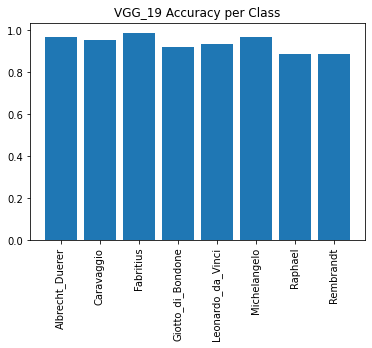

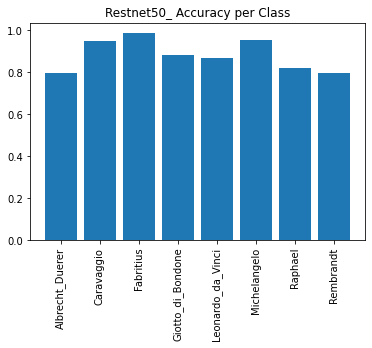

In [34]:
import matplotlib.pyplot as plt
plt.bar(x = classes_to_int.keys(), height = vgg_19_accuracies_per_class.values())
plt.title('VGG_19 Accuracy per Class')
plt.xticks(rotation=90)
plt.show()


plt.bar(x = classes_to_int.keys(), height = re50_accuracies_per_class.values())
plt.title('Restnet50_ Accuracy per Class')
plt.xticks(rotation=90)
plt.show()

In [50]:
from sklearn.metrics import classification_report
print('VGG19 Model')
print(classification_report(y_test, y_pred_vgg19, target_names= list(classes_to_int.keys()) ))

VGG19 Model
                   precision    recall  f1-score   support

  Albrecht_Duerer       0.92      0.98      0.95        66
       Caravaggio       0.57      0.36      0.44        11
        Fabritius       0.00      0.00      0.00         3
Giotto_di_Bondone       0.60      0.88      0.71        24
Leonardo_da_Vinci       0.86      0.62      0.72        29
     Michelangelo       1.00      0.30      0.46        10
          Raphael       0.46      0.73      0.56        22
        Rembrandt       0.80      0.69      0.74        52

         accuracy                           0.75       217
        macro avg       0.65      0.57      0.57       217
     weighted avg       0.77      0.75      0.74       217



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
print('Restnet50 Model')
print(classification_report(y_test, y_pred_resnet50, target_names= list(classes_to_int.keys()) ))


Restnet50 Model
                   precision    recall  f1-score   support

  Albrecht_Duerer       0.62      0.85      0.72        66
       Caravaggio       0.00      0.00      0.00        11
        Fabritius       0.00      0.00      0.00         3
Giotto_di_Bondone       0.46      0.50      0.48        24
Leonardo_da_Vinci       0.00      0.00      0.00        29
     Michelangelo       0.00      0.00      0.00        10
          Raphael       0.26      0.41      0.32        22
        Rembrandt       0.56      0.71      0.63        52

         accuracy                           0.53       217
        macro avg       0.24      0.31      0.27       217
     weighted avg       0.40      0.53      0.45       217



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Look closer at all the metrics

In [52]:
# Compile the model
my_vgg19.compile(Adam(lr=0.0001), 
                  loss='sparse_categorical_crossentropy',
                  metrics='categorical_accuracy')

In [53]:
# Train the model
my_vgg19.fit(
    x=train_batches,
    validation_data=val_batches,
    epochs=25,
    verbose=1,
   
)

Epoch 1/25
87/87 [==============================] - 10s 98ms/step - loss: 0.3622 - categorical_accuracy: 0.3039 - val_loss: 0.9081 - val_categorical_accuracy: 0.3237
Epoch 2/25
87/87 [==============================] - 8s 96ms/step - loss: 0.2549 - categorical_accuracy: 0.3074 - val_loss: 0.9363 - val_categorical_accuracy: 0.3237
Epoch 3/25
87/87 [==============================] - 8s 94ms/step - loss: 0.3210 - categorical_accuracy: 0.3065 - val_loss: 0.9021 - val_categorical_accuracy: 0.3410
Epoch 4/25
87/87 [==============================] - 8s 94ms/step - loss: 0.3630 - categorical_accuracy: 0.3229 - val_loss: 0.9455 - val_categorical_accuracy: 0.3179
Epoch 5/25
87/87 [==============================] - 8s 96ms/step - loss: 0.3250 - categorical_accuracy: 0.2707 - val_loss: 0.8801 - val_categorical_accuracy: 0.2948
Epoch 6/25
87/87 [==============================] - 8s 96ms/step - loss: 0.3083 - categorical_accuracy: 0.3142 - val_loss: 0.9551 - val_categorical_accuracy: 0.3526
Epoch 7/2

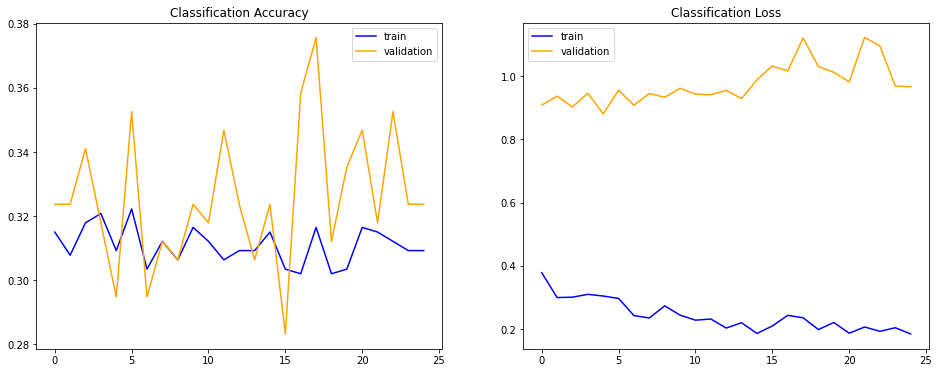

In [54]:
def plot_training_history(history: History):
  plt.figure(figsize=(16,6))
  plt.subplot(1,2,1)
  plt.title('Classification Accuracy')
  plt.plot(history.history['categorical_accuracy'], color='blue', label='train')
  plt.plot(history.history['val_categorical_accuracy'], color='orange', label='validation')
  plt.legend()

  plt.subplot(1,2,2)
  plt.title('Classification Loss')
  plt.plot(history.history['loss'], color='blue', label='train')
  plt.plot(history.history['val_loss'], color='orange', label='validation')
  plt.legend()

  plt.show()

plot_training_history(my_vgg19.history)

In [56]:
my_vgg19.evaluate(test_batches)

28/28 [==============================] - 1s 30ms/step - loss: 0.9274 - categorical_accuracy: 0.3272


[0.9273649454116821, 0.3271889388561249]

In [57]:
y_pred_vgg19 = np.argmax(my_vgg19.predict(x=test_batches, verbose=1), axis = 1)


28/28 [==============================] - 1s 29ms/step


In [58]:
vgg_19_accuracies_per_class = get_accuracy_by_class(y_test, y_pred_vgg19, classes_to_int.values())


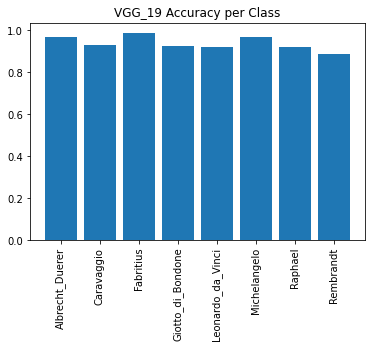

In [59]:
import matplotlib.pyplot as plt
plt.bar(x = classes_to_int.keys(), height = vgg_19_accuracies_per_class.values())
plt.title('VGG_19 Accuracy per Class')
plt.xticks(rotation=90)
plt.show()


In [60]:
#### , not exactly accuracy because True Negatives are not consindered: 
from sklearn.metrics import confusion_matrix

matrix_vgg19 = confusion_matrix(y_test, y_pred_vgg19)
vgg_19_accuracies_per_class = matrix_vgg19.diagonal()/matrix_vgg19.sum(axis=1)


In [61]:
vgg_19_accuracies_per_class

array([0.98484848, 0.36363636, 0.33333333, 0.75      , 0.55172414,
       0.4       , 0.81818182, 0.71153846])

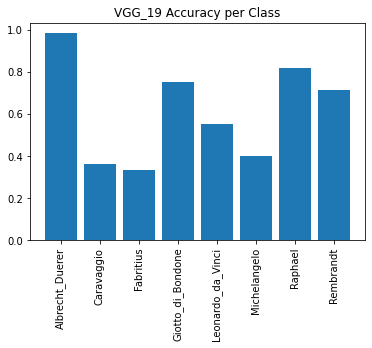

In [62]:
import matplotlib.pyplot as plt
plt.bar(x = classes_to_int.keys(), height = vgg_19_accuracies_per_class)
plt.title('VGG_19 Accuracy per Class')
plt.xticks(rotation=90)
plt.show()

In [64]:
print('VGG19 Model')
print(classification_report(y_test, y_pred_vgg19, target_names= list(classes_to_int.keys()) ))

VGG19 Model
                   precision    recall  f1-score   support

  Albrecht_Duerer       0.92      0.98      0.95        66
       Caravaggio       0.33      0.36      0.35        11
        Fabritius       0.50      0.33      0.40         3
Giotto_di_Bondone       0.64      0.75      0.69        24
Leonardo_da_Vinci       0.76      0.55      0.64        29
     Michelangelo       0.80      0.40      0.53        10
          Raphael       0.58      0.82      0.68        22
        Rembrandt       0.79      0.71      0.75        52

         accuracy                           0.75       217
        macro avg       0.67      0.61      0.62       217
     weighted avg       0.76      0.75      0.75       217

